In [50]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.ticker as mtick
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [51]:
base_path = os.path.join(os.getcwd(), '..', 'steam-insights-main')

games_df_path = os.path.join(base_path, 'games.csv')
reviews_path = os.path.join(base_path, 'reviews.csv')

In [ ]:

games = pd.read_csv(
    games_df_path,
    usecols=["app_id", "name", "release_date"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip'
)
games = games.dropna(subset=['name'])

reviews = pd.read_csv(
    reviews_path,
    usecols=["app_id", "review_score"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
print(reviews.dtypes)

print("Number of 'N' or null values in review_score before dropping:", reviews['review_score'].isna().sum() + (reviews['review_score'] == 'N').sum())

reviews['review_score'] = pd.to_numeric(reviews['review_score'], errors='coerce')

reviews = reviews.dropna(subset=['review_score'])


app_id           int64
review_score    object
dtype: object
Number of 'N' or null values in review_score before dropping: 5


In [ ]:

df_merged = pd.merge(games, reviews, on="app_id", how="inner")

display(df_merged.head())
print(f"Total rows in merged data: {df_merged.shape[0]}")

,app_id,name,release_date,review_score
0,10,Counter-Strike,2000-11-01,9.0
1,20,Team Fortress Classic,1999-04-01,8.0
2,30,Day of Defeat,2003-05-01,8.0
3,40,Deathmatch Classic,2001-06-01,8.0
4,50,Half-Life: Opposing Force,1999-11-01,9.0


Total rows in merged data: 140077


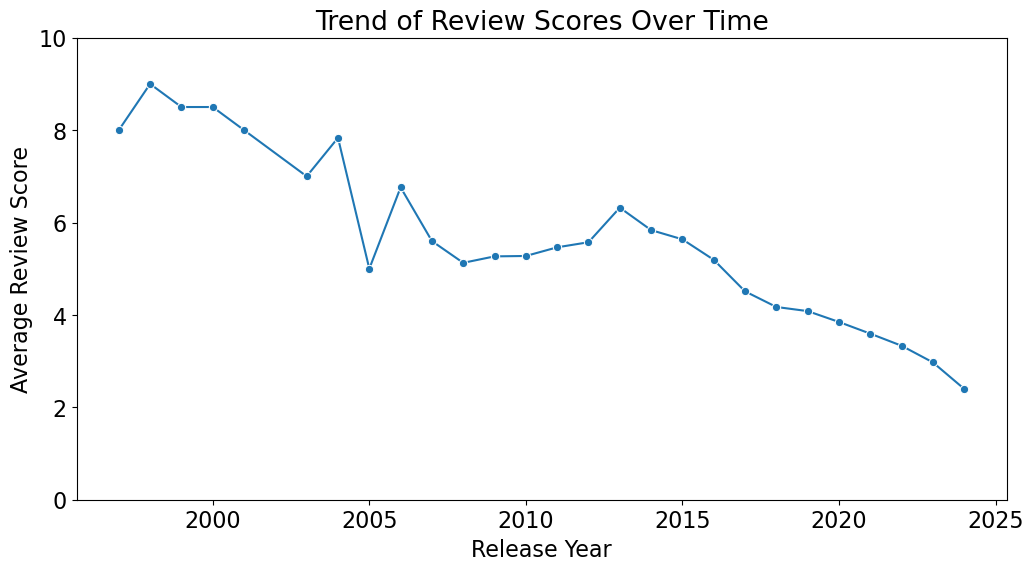

In [ ]:
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='review_score', data=yearly_reviews, marker='o')
plt.xlabel("Release Year")
plt.ylabel("Average Review Score")
plt.title("Trend of Review Scores Over Time")
plt.ylim(0, 10)
plt.show()




In [ ]:

print(yearly_reviews)

    release_year  review_score
0           1997      8.000000
1           1998      9.000000
2           1999      8.500000
3           2000      8.500000
4           2001      8.000000
5           2003      7.000000
6           2004      7.833333
7           2005      5.000000
8           2006      6.761194
9           2007      5.598214
10          2008      5.127551
11          2009      5.267176
12          2010      5.275862
13          2011      5.463492
14          2012      5.573265
15          2013      6.321862
16          2014      5.835658
17          2015      5.636161
18          2016      5.193064
19          2017      4.509780
20          2018      4.171877
21          2019      4.082511
22          2020      3.847210
23          2021      3.594327
24          2022      3.332316
25          2023      2.972169
26          2024      2.397875


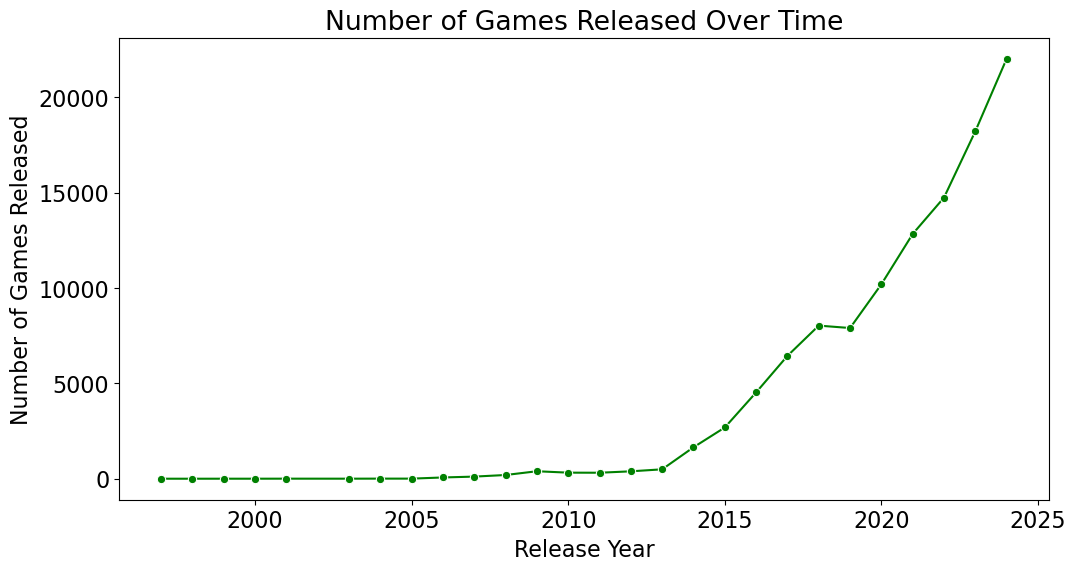

In [ ]:

yearly_game_counts = df_merged.groupby('release_year').size().reset_index(name='num_games')

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='num_games', data=yearly_game_counts, marker='o', color='green')
plt.xlabel("Release Year")
plt.ylabel("Number of Games Released")
plt.title("Number of Games Released Over Time")
plt.show()





Average Review Score for all games: 3.56


<Figure size 1200x600 with 0 Axes>

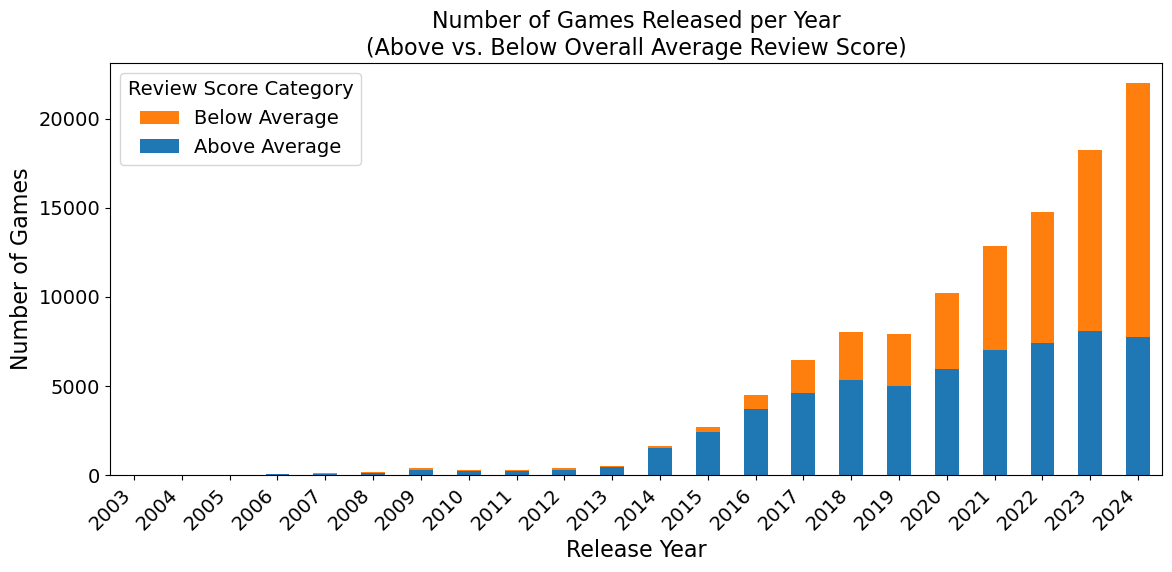

In [ ]:

df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

df_merged = df_merged[df_merged['release_year'] >= 2003]

avg_review = df_merged['review_score'].mean()
print(f"Average Review Score for all games: {avg_review:.2f}")

df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot[['Above Average', 'Below Average']]  
yearly_pivot = yearly_pivot.sort_index()


plt.figure(figsize=(12, 6))
ax = yearly_pivot.plot(kind='bar', stacked=True, figsize=(12,6))

TITLE_FONTSIZE = 16
XLABEL_FONTSIZE = 16
YLABEL_FONTSIZE = 16
XTICKLABEL_FONTSIZE = 14
YTICKLABEL_FONTSIZE = 14
LEGEND_TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 14

plt.xlabel("Release Year", fontsize=XLABEL_FONTSIZE)
plt.ylabel("Number of Games", fontsize=YLABEL_FONTSIZE)
plt.title("Number of Games Released per Year\n(Above vs. Below Overall Average Review Score)", fontsize=TITLE_FONTSIZE)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Review Score Category", 
          title_fontsize=LEGEND_TITLE_FONTSIZE, fontsize=LEGEND_FONTSIZE)

plt.xticks(rotation=45, ha='right', fontsize=XTICKLABEL_FONTSIZE)
plt.yticks(fontsize=YTICKLABEL_FONTSIZE)
plt.savefig('bar1.pdf', format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:

df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')


yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')


yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot.sort_index()

display(yearly_pivot.head(30))



score_category,Above Average,Below Average
release_year,,
2003,3.0,0.0
2004,6.0,0.0
2005,4.0,2.0
2006,61.0,6.0
2007,88.0,24.0
2008,145.0,51.0
2009,309.0,84.0
2010,253.0,66.0
2011,262.0,53.0


<Figure size 1200x600 with 0 Axes>

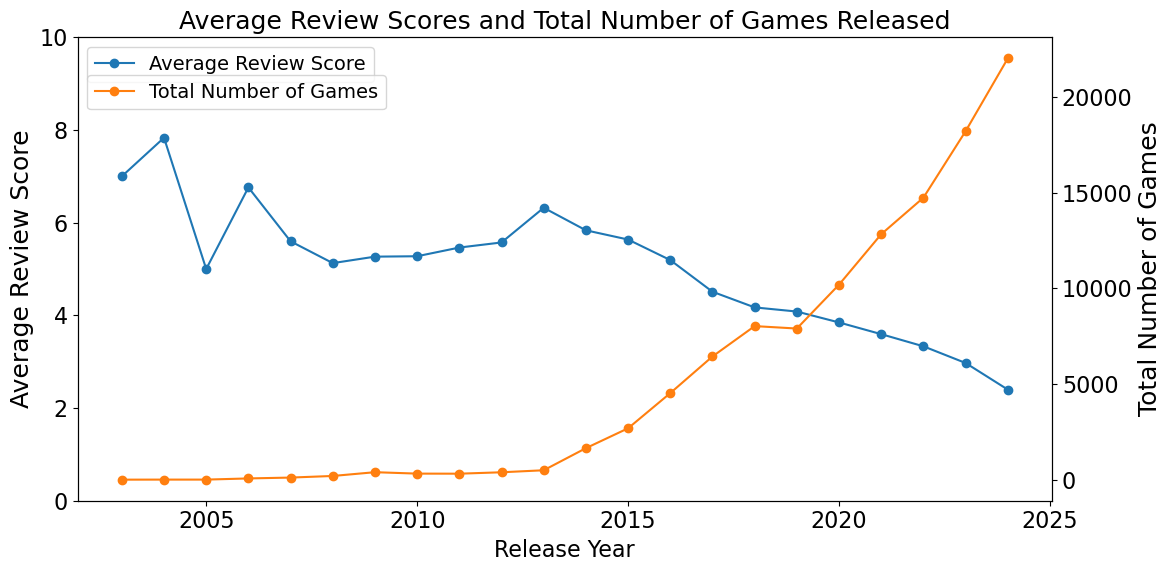

In [ ]:

yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()
total_games = df_merged.groupby('release_year').size().reset_index(name='total_games')

plt.figure(figsize=(12, 6))

fig, ax1 = plt.subplots(figsize=(12, 6))


plt.rcParams.update({'font.size': 16})  
plt.title("Average Review Scores and Total Number of Games Released", fontsize=18)


ax1.set_xlabel("Release Year", fontsize=16)
ax1.set_ylabel("Average Review Score", color='black', fontsize=18)
ax1.plot(yearly_reviews['release_year'], yearly_reviews['review_score'], marker='o', color='#1f77b4', label="Average Review Score")
ax1.tick_params(axis='y', labelcolor='black', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_ylim(0, 10)


ax2 = ax1.twinx()
ax2.set_ylabel("Total Number of Games", color='black', fontsize=18)
ax2.plot(total_games['release_year'], total_games['total_games'], marker='o', color='#ff7f0f', label="Total Number of Games")
ax2.tick_params(axis='y', labelcolor='black', labelsize=16)

ax1.legend(fontsize=14, loc='upper left')
ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(0, 0.94))

fig.tight_layout()

plt.savefig('doubleLine.pdf', format='pdf', bbox_inches='tight')

plt.show()


In [ ]:

total_games_2003 = total_games[total_games['release_year'] >= 2003].copy()

X    = total_games_2003['release_year'].values.reshape(-1, 1)
y = total_games_2003['total_games'].values        

lin_reg = LinearRegression().fit(X, y)
print("Coefficient:", lin_reg.coef_[0])
print("Intercept:", lin_reg.intercept_)

future_years = np.array([2024, 2025, 2026, 2027, 2028, 2029]).reshape(-1, 1)
future_predictions = lin_reg.predict(future_years)
forecast_df = pd.DataFrame({'release_year': future_years.flatten(), 'predicted_total_games': future_predictions})
print(forecast_df)

all_years = np.concatenate([total_games_2003['release_year'].values, future_years.flatten()])
all_years = np.sort(all_years)

all_predictions = lin_reg.predict(all_years.reshape(-1, 1))


Coefficient: 907.3845285149633
Intercept: -1821948.3845285152
   release_year  predicted_total_games
0          2024           14597.901186
1          2025           15505.285714
2          2026           16412.670243
3          2027           17320.054771
4          2028           18227.439300
5          2029           19134.823828


Coefficient: 907.3845285149633
Intercept: -1821948.3845285152
   release_year  predicted_total_games
0          2024           14597.901186
1          2025           15505.285714
2          2026           16412.670243
3          2027           17320.054771
4          2028           18227.439300
5          2029           19134.823828
R-squared: 0.7781927682030833


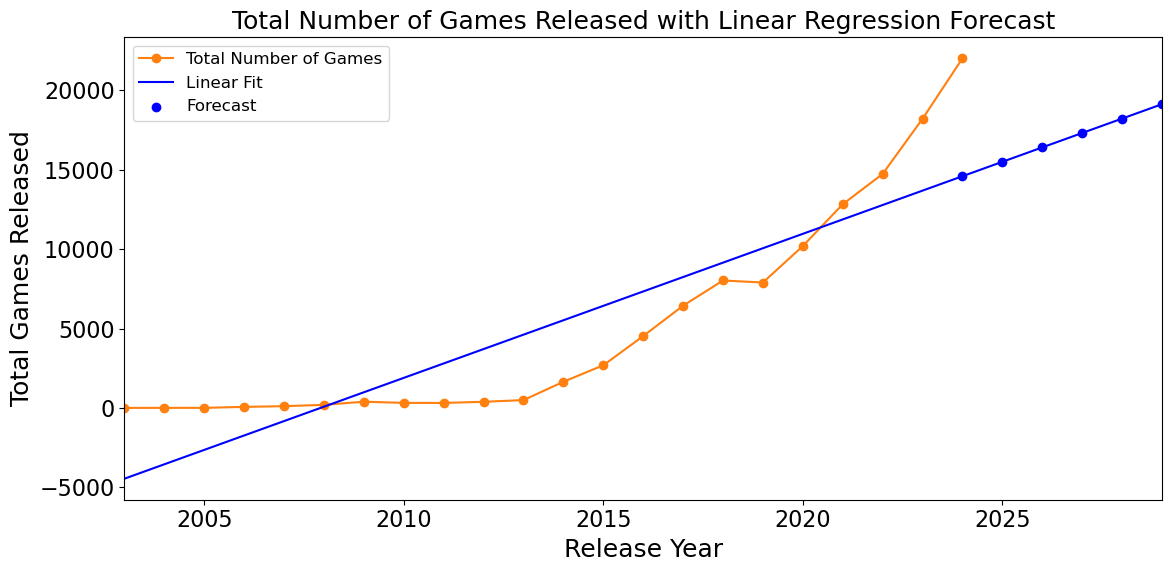

In [ ]:

total_games_2003 = total_games[total_games['release_year'] >= 2003].copy()

X = total_games_2003['release_year'].values.reshape(-1, 1) 
y = total_games_2003['total_games'].values              

lin_reg = LinearRegression().fit(X, y)
print("Coefficient:", lin_reg.coef_[0])
print("Intercept:", lin_reg.intercept_)

future_years = np.array([2024, 2025, 2026, 2027, 2028, 2029]).reshape(-1, 1)
future_predictions = lin_reg.predict(future_years)
forecast_df = pd.DataFrame({'release_year': future_years.flatten(), 'predicted_total_games': future_predictions})
print(forecast_df)

all_years = np.concatenate([total_games_2003['release_year'].values, future_years.flatten()])
all_years = np.sort(all_years)

all_predictions = lin_reg.predict(all_years.reshape(-1, 1))


y_predicted = lin_reg.predict(X) 
r2 = r2_score(y, y_predicted)
print("R-squared:", r2)

plt.figure(figsize=(12, 6))

plt.plot(total_games['release_year'], total_games['total_games'], marker='o', color='#ff7f0f', label="Total Number of Games")

plt.plot(all_years, all_predictions, color='blue', label='Linear Fit')
plt.scatter(forecast_df['release_year'], forecast_df['predicted_total_games'], marker='o', color='blue', label='Forecast')

plt.xlabel('Release Year', fontsize=18)
plt.ylabel('Total Games Released', fontsize=18)
plt.title('Total Number of Games Released with Linear Regression Forecast', fontsize=18)
plt.xlim(2003, 2029)
plt.legend(fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('regression.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:

total_games_2003 = total_games[total_games['release_year'] >= 2003].copy()

total_games_ts = total_games_2003.set_index('release_year')['total_games']

                               SARIMAX Results                                
Dep. Variable:            total_games   No. Observations:                   22
Model:                ARIMA(10, 1, 2)   Log Likelihood                -280.337
Date:                Sun, 30 Mar 2025   AIC                            586.674
Time:                        19:19:56   BIC                            600.253
Sample:                             0   HQIC                           589.621
                                 - 22                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2340      0.024     -9.578      0.000      -0.282      -0.186
ar.L2          0.0868      0.021      4.210      0.000       0.046       0.127
ar.L3          0.8221      0.020     40.531      0.0

/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base

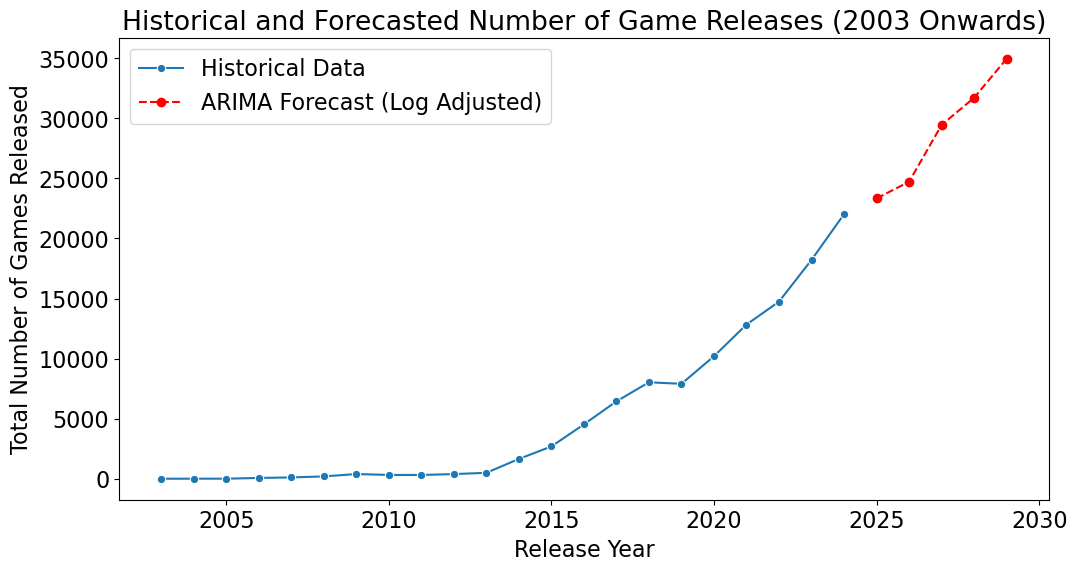

In [ ]:

model_total = sm.tsa.ARIMA(total_games_ts, order=(10, 1, 2))
model_total_fit = model_total.fit()
print(model_total_fit.summary())

forecast_steps = 5
forecast_total = model_total_fit.forecast(steps=forecast_steps)
forecast_years = np.arange(total_games_ts.index.max() + 1, total_games_ts.index.max() + forecast_steps + 1)
aggregated_forecast_df = pd.DataFrame({
    'release_year': forecast_years,
    'predicted_total_games': forecast_total
})
print("Aggregated Forecast:")
print(aggregated_forecast_df)


plt.figure(figsize=(12, 6))
sns.lineplot(x=total_games_2003['release_year'], y=total_games_2003['total_games'], marker='o', label='Historical Data')
plt.plot(aggregated_forecast_df['release_year'], aggregated_forecast_df['predicted_total_games'], marker='o', linestyle='--', color='red', label='ARIMA Forecast')
plt.xlabel("Release Year")
plt.ylabel("Total Number of Games Released")
plt.title("Historical and Forecasted Number of Game Releases (2003 Onwards)")
plt.legend()
plt.show()

In [ ]:

yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot.sort_index()
print("Historical stacked counts:")
print(yearly_pivot)

Historical stacked counts:
score_category  Above Average  Below Average
release_year                                
2003                      3.0            0.0
2004                      6.0            0.0
2005                      4.0            2.0
2006                     61.0            6.0
2007                     88.0           24.0
2008                    145.0           51.0
2009                    309.0           84.0
2010                    253.0           66.0
2011                    262.0           53.0
2012                    323.0           66.0
2013                    470.0           24.0
2014                   1531.0          118.0
2015                   2430.0          258.0
2016                   3745.0          782.0
2017                   4640.0         1802.0
2018                   5353.0         2676.0
2019                   4982.0         2920.0
2020                   5957.0         4240.0
2021                   7000.0         5833.0
2022                   7425.

In [ ]:

historical_summary = yearly_pivot.copy()
historical_summary['total_games'] = historical_summary['Above Average'] + historical_summary['Below Average']
historical_summary['pct_above'] = (historical_summary['Above Average'] / historical_summary['total_games']) * 100
historical_summary['pct_below'] = (historical_summary['Below Average'] / historical_summary['total_games']) * 100

historical_summary = historical_summary[['total_games', 'pct_above', 'pct_below']]
historical_summary = historical_summary.reset_index()

print("Historical Summary:")
print(historical_summary)


Historical Summary:
score_category  release_year  total_games   pct_above  pct_below
0                       2003          3.0  100.000000   0.000000
1                       2004          6.0  100.000000   0.000000
2                       2005          6.0   66.666667  33.333333
3                       2006         67.0   91.044776   8.955224
4                       2007        112.0   78.571429  21.428571
5                       2008        196.0   73.979592  26.020408
6                       2009        393.0   78.625954  21.374046
7                       2010        319.0   79.310345  20.689655
8                       2011        315.0   83.174603  16.825397
9                       2012        389.0   83.033419  16.966581
10                      2013        494.0   95.141700   4.858300
11                      2014       1649.0   92.844148   7.155852
12                      2015       2688.0   90.401786   9.598214
13                      2016       4527.0   82.725867  17.274133
14   

In [ ]:

future_steps = 5
last_year = yearly_pivot.index.max()
future_years = np.arange(last_year + 1, last_year + 1 + future_steps)

above_ts = yearly_pivot['Above Average']
below_ts = yearly_pivot['Below Average']

model_above = sm.tsa.ARIMA(above_ts, order=(8,1,1))
model_above_fit = model_above.fit()
forecast_above = model_above_fit.forecast(steps=future_steps)

model_below = sm.tsa.ARIMA(below_ts, order=(5,1,1))
model_below_fit = model_below.fit()
forecast_below = model_below_fit.forecast(steps=future_steps)

/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base

In [ ]:

forecast_above_arr = np.array(forecast_above)
forecast_below_arr = np.array(forecast_below)

adjusted_forecast_above = []
adjusted_forecast_below = []
for i in range(forecast_steps):
    seg_sum = forecast_above_arr[i] + forecast_below_arr[i]
    if seg_sum == 0:
        factor = 0
    else:
        factor = aggregated_forecast_df.iloc[i]['predicted_total_games'] / seg_sum
    adjusted_forecast_above.append(forecast_above_arr[i] * factor)
    adjusted_forecast_below.append(forecast_below_arr[i] * factor)

forecast_seg_df = pd.DataFrame({
    'release_year': future_years,
    'predicted_above': adjusted_forecast_above,
    'predicted_below': adjusted_forecast_below
})
forecast_seg_df['total_predicted'] = forecast_seg_df['predicted_above'] + forecast_seg_df['predicted_below']
forecast_seg_df['pct_above'] = (forecast_seg_df['predicted_above'] / forecast_seg_df['total_predicted']) * 100
forecast_seg_df['pct_below'] = (forecast_seg_df['predicted_below'] / forecast_seg_df['total_predicted']) * 100

print("\nAdjusted Forecasted Counts and Percentages:")
print(forecast_seg_df)



Adjusted Forecasted Counts and Percentages:
   release_year  predicted_above  predicted_below  total_predicted  pct_above  \
0          2025      6592.169578     16741.920262     23334.089840  28.251239   
1          2026      5697.048618     19021.270247     24718.318864  23.047881   
2          2027      5905.815686     23540.526358     29446.342045  20.056195   
3          2028      5338.959839     26370.852022     31709.811861  16.836933   
4          2029      5148.580293     29811.039390     34959.619683  14.727221   

   pct_below  
0  71.748761  
1  76.952119  
2  79.943805  
3  83.163067  
4  85.272779  


<Figure size 2200x1000 with 0 Axes>

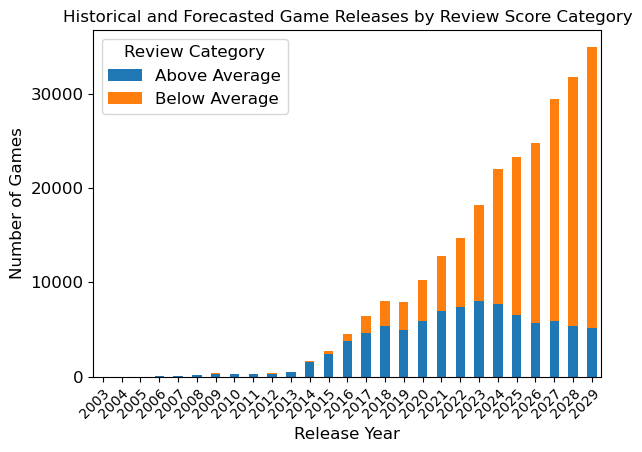

In [ ]:

future_df = forecast_seg_df.copy().set_index('release_year')[['predicted_above', 'predicted_below']]
future_df.columns = ['Above Average', 'Below Average']

combined_df = pd.concat([yearly_pivot, future_df]).sort_index()

combined_df_filtered = combined_df[(combined_df.index >= 2003) & (combined_df.index <= 2029)]

plt.figure(figsize=(22, 10))

ax = combined_df_filtered.plot(kind='bar', stacked=True) 

plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha='right',  
         rotation_mode='anchor', 
         va='top',
         fontsize=10)  

plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Number of Games", fontsize=12)
plt.title("Historical and Forecasted Game Releases by Review Score Category", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Review Category', fontsize=12, title_fontsize=12)

plt.savefig('predictedBar.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
total_games_per_year = df_merged.groupby('release_year').size().rename('total_games')

avg_review = df_merged['review_score'].mean()

above_avg_per_year = df_merged[df_merged['review_score'] >= avg_review].groupby('release_year').size().rename('above_avg_games')

yearly_data = pd.DataFrame({'total_games': total_games_per_year, 'above_avg_games': above_avg_per_year}).fillna(0)

yearly_data['prop_above'] = yearly_data['above_avg_games'] / yearly_data['total_games']

yearly_data = yearly_data[yearly_data.index >= 2003].reset_index()

X = sm.add_constant(yearly_data['total_games'])
model = sm.OLS(yearly_data['prop_above'], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             prop_above   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     71.86
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           4.71e-08
Time:                        19:20:04   Log-Likelihood:                 23.756
No. Observations:                  22   AIC:                            -43.51
Df Residuals:                      20   BIC:                            -41.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8665      0.023     37.233      

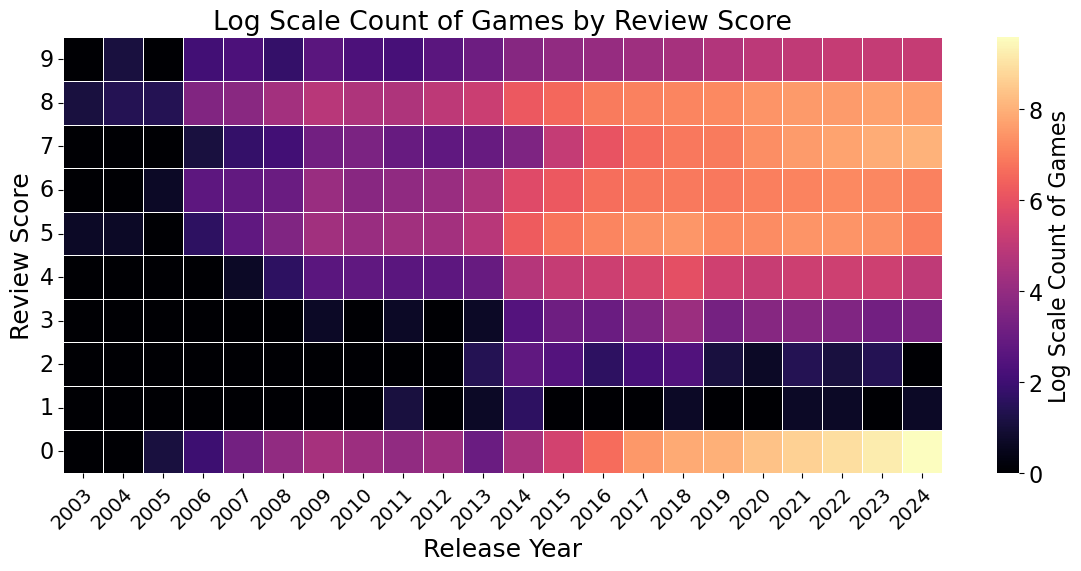

In [ ]:

df_filtered = df_merged[df_merged['release_year'] >= 2003]

df_filtered['review_score'] = df_filtered['review_score'].astype(int)

heatmap_data = df_filtered.groupby(['review_score', 'release_year']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
log_heatmap_data = np.log1p(heatmap_data)
ax = sns.heatmap(
    log_heatmap_data, cmap='magma', linewidths=0.5,
    cbar_kws={'label': 'Log Scale Count of Games'}
)
plt.ylabel("Review Score", fontsize=18)
plt.xlabel("Release Year", fontsize=18)
plt.title("Log Scale Count of Games by Review Score")

plt.yticks(rotation=0)

plt.setp(ax.get_xticklabels(),
         rotation=45,
         ha='right',
         rotation_mode='anchor',
         va='top',
         fontsize=14)

plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('heatmap.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [73]:
forecast_summary = forecast_seg_df[['release_year', 'total_predicted', 'pct_above', 'pct_below']].copy()
forecast_summary.columns = ['release_year', 'total_games', 'pct_above', 'pct_below']

print("Forecast Summary:")
print(forecast_summary)


Forecast Summary:
   release_year   total_games  pct_above  pct_below
0          2025  23334.089840  28.251239  71.748761
1          2026  24718.318864  23.047881  76.952119
2          2027  29446.342045  20.056195  79.943805
3          2028  31709.811861  16.836933  83.163067
4          2029  34959.619683  14.727221  85.272779
